In [1]:
!pip install transformers torch torchvision torchaudio
!pip install sentencepiece
!pip install gradio
!pip install textblob


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, AutoModelForCausalLM
from textblob import TextBlob
import gradio as gr


In [3]:
# Emotion detection model (Google/GoEmotions)
emotion_model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
emotion_classifier = pipeline("text-classification", model=emotion_model_name, return_all_scores=False)

# Chatbot conversational model (DialoGPT)
chatbot_model_name = "microsoft/DialoGPT-medium"
chat_tokenizer = AutoTokenizer.from_pretrained(chatbot_model_name)
chat_model = AutoModelForCausalLM.from_pretrained(chatbot_model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [4]:
chat_history_ids = None

def ai_therapist(user_input):
    global chat_history_ids

    # Emotion detection
    emotion = emotion_classifier(user_input)[0]['label']

    # Sentiment analysis
    sentiment = TextBlob(user_input).sentiment.polarity
    if sentiment > 0:
        mood = "positive"
    elif sentiment < 0:
        mood = "negative"
    else:
        mood = "neutral"

    # Response generation
    new_input_ids = chat_tokenizer.encode(user_input + chat_tokenizer.eos_token, return_tensors='pt')
    bot_input_ids = torch.cat([chat_history_ids, new_input_ids], dim=-1) if chat_history_ids is not None else new_input_ids

    chat_history_ids = chat_model.generate(
        bot_input_ids, max_length=1000, pad_token_id=chat_tokenizer.eos_token_id,
        temperature=0.7, top_k=50, top_p=0.9
    )

    response = chat_tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)

    # Combine emotional context
    emotional_response = ""
    if emotion in ["sadness", "grief", "fear", "anxiety"]:
        emotional_response = "I'm sorry you're feeling that way. Want to talk more about it?"
    elif emotion in ["joy", "love", "gratitude"]:
        emotional_response = "That's wonderful to hear! Tell me more about what makes you happy."
    elif emotion in ["anger", "disgust"]:
        emotional_response = "It sounds like something upset you. Would you like to unpack that together?"
    else:
        emotional_response = "I'm here to listen and support you."

    return f"**Emotion detected:** {emotion} ({mood})\n\n🧠 **Therapist:** {emotional_response}\n💬 **Bot:** {response}"


In [5]:
interface = gr.Interface(
    fn=ai_therapist,
    inputs=gr.Textbox(lines=3, placeholder="Tell me how you feel today..."),
    outputs="markdown",
    title="🧠 AI Therapist Chatbot (Emotion + NLP)",
    description="An AI-powered therapist that listens, understands emotions, and responds empathetically."
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dc41e92e726d1113ab.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


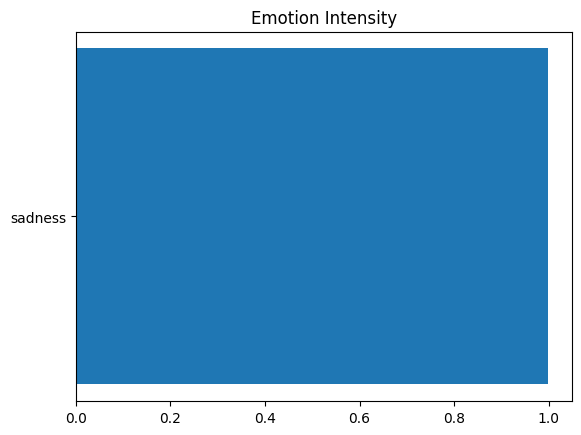

In [6]:
import matplotlib.pyplot as plt

def plot_emotion_distribution(text):
    emotions = emotion_classifier(text)
    labels = [e['label'] for e in emotions]
    scores = [e['score'] for e in emotions]
    plt.barh(labels, scores)
    plt.title("Emotion Intensity")
    plt.show()

plot_emotion_distribution("I'm feeling very lonely and anxious today.")
